# Forward Forward Algorithm with No Backpropagation

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Epoch 1 completed.
Epoch 2 completed.
Epoch 3 completed.
Epoch 4 completed.
Epoch 5 completed.
Epoch 6 completed.
Epoch 7 completed.
Epoch 8 completed.
Epoch 9 completed.
Epoch 10 completed.
Epoch 11 completed.
Epoch 12 completed.
Epoch 13 completed.
Epoch 14 completed.
Epoch 15 completed.
Epoch 16 completed.
Epoch 17 completed.
Epoch 18 completed.
Epoch 19 completed.
Epoch 20 completed.
Epoch 21 completed.
Epoch 22 completed.
Epoch 23 completed.
Epoch 24 completed.
Epoch 25 completed.
Epoch 26 completed.
Epoch 27 completed.
Epoch 28 completed.
Epoch 29 completed.
Epoch 30 completed.
Epoch 31 completed.
Epoch 32 completed.
Epoch 33 completed.
Epoch 34 completed.
Epoch 35 completed.
Epoch 36 completed.
Epoch 37 completed.
Epoch 38 completed.
Epoch 39 completed.
Epoch 40 completed.
Epoch 41 completed.
Epoch 42 completed.
Epoch 43 completed.
Epoch 44 completed.
Epoch 45 completed.
Epoch 46 completed.
Epoch 47 completed.
Epoch 48 completed.
Epoch 49 completed.
Epoch 50 completed.

Train RM

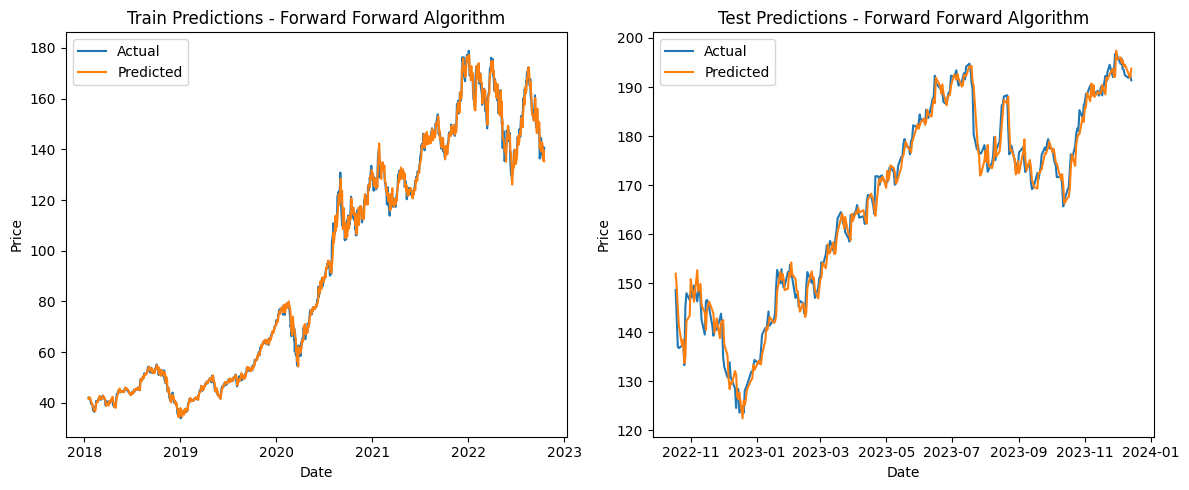

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf

# Set seed
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Load and preprocess data
def download_data():
    df = yf.download("AAPL", start="2018-01-01", end="2023-12-31")
    return df[['Close']]

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

data = download_data()
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
seq_length = 10

train_size = int(0.8 * len(scaled_data))
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train_flat = X_train.reshape(X_train.shape[0], -1).astype(np.float32)
X_test_flat = X_test.reshape(X_test.shape[0], -1).astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

# FF Layer
def relu(x):
    return tf.nn.relu(x)

class FFLayer(tf.keras.layers.Layer):
    def __init__(self, input_dim, units):
        super().__init__()
        self.units = units
        self.w = self.add_weight(shape=(input_dim, units),
                                 initializer='random_normal',
                                 dtype=tf.float32,
                                 trainable=False)
        self.b = self.add_weight(shape=(units,),
                                 initializer='zeros',
                                 dtype=tf.float32,
                                 trainable=False)

    def call(self, inputs):
        return relu(tf.matmul(inputs, self.w) + self.b)

    def local_update(self, pos_input, neg_input, top_down=None, lr=0.01):
        pos_act = relu(tf.matmul(pos_input, self.w) + self.b)
        neg_act = relu(tf.matmul(neg_input, self.w) + self.b)

        if top_down is not None:
            pos_act *= top_down
            neg_act *= top_down

        delta_w = lr * (tf.matmul(tf.transpose(pos_input), pos_act) -
                        tf.matmul(tf.transpose(neg_input), neg_act)) / pos_input.shape[0]
        delta_b = lr * tf.reduce_mean(pos_act - neg_act, axis=0)

        self.w.assign_add(delta_w)
        self.b.assign_add(delta_b)

        return pos_act, tf.reduce_mean(tf.square(pos_act), axis=1), tf.reduce_mean(tf.square(neg_act), axis=1)

# Model
def fit_linear_mapping(h_final, y_true):
    return np.linalg.pinv(h_final) @ y_true

class FFModel(tf.keras.Model):
    def __init__(self, input_dim):
        super().__init__()
        self.ff1 = FFLayer(input_dim, 128)
        self.ff2 = FFLayer(128, 64)
        self.ff3 = FFLayer(64, 32)  # No backprop, purely FF

    def call(self, x):
        x1 = self.ff1(x)
        x2 = self.ff2(x1)
        x3 = self.ff3(x2)
        return x3

# Data Pairs
def generate_pos_neg_pairs(X, y, batch_size):
    indices = np.random.choice(len(X), batch_size, replace=False)
    X_pos = X[indices]
    y_pos = y[indices]
    neg_indices = np.random.permutation(indices)
    X_neg = X[indices]
    y_neg = y[neg_indices]
    return X_pos, y_pos, X_neg, y_neg

# Training
def train_ff(model, X_train, y_train, epochs=20, batch_size=32):
    for epoch in range(epochs):
        for i in range(0, len(X_train), batch_size):
            if i + batch_size > len(X_train):
                continue
            X_pos, y_pos, X_neg, y_neg = generate_pos_neg_pairs(X_train, y_train, batch_size)

            h1_pos = model.ff1(X_pos)
            h1_neg = model.ff1(X_neg)

            h2_pos, _, _ = model.ff2.local_update(h1_pos, h1_neg)
            h2_neg = model.ff2(h1_neg)

            _, _, _ = model.ff3.local_update(h2_pos, h2_neg)
            _, _, _ = model.ff1.local_update(X_pos, X_neg)

        print(f"Epoch {epoch + 1} completed.")

# Evaluation

def evaluate_and_plot(model, X_train, y_train, X_test, y_test, scaler):
    H_train = model(X_train).numpy()
    H_test = model(X_test).numpy()

    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    W_linear = fit_linear_mapping(H_train, y_train)
    y_train_pred = H_train @ W_linear
    y_test_pred = H_test @ W_linear

    y_train_inv = scaler.inverse_transform(y_train)
    y_test_inv = scaler.inverse_transform(y_test)
    y_train_pred_inv = scaler.inverse_transform(y_train_pred)
    y_test_pred_inv = scaler.inverse_transform(y_test_pred)

    train_rmse = np.sqrt(mean_squared_error(y_train_inv, y_train_pred_inv))
    test_rmse = np.sqrt(mean_squared_error(y_test_inv, y_test_pred_inv))

    print(f"\nTrain RMSE: {train_rmse:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")

    # Generate matching date indices
    full_dates = data.index[seq_length:]  # shift for sequences
    train_dates = full_dates[:len(y_train)]
    test_dates = full_dates[len(y_train):len(y_train) + len(y_test)]

    # Plot with dates
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_dates, y_train_inv, label='Actual')
    plt.plot(train_dates, y_train_pred_inv, label='Predicted')
    plt.title("Train Predictions - Forward Forward Algorithm")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(test_dates, y_test_inv, label='Actual')
    plt.plot(test_dates, y_test_pred_inv, label='Predicted')
    plt.title("Test Predictions - Forward Forward Algorithm")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()

    plt.tight_layout()
    plt.show()


# Run
if __name__ == "__main__":
    model = FFModel(input_dim=X_train_flat.shape[1])
    train_ff(model, X_train_flat, y_train, epochs=50)
    evaluate_and_plot(model, X_train_flat, y_train, X_test_flat, y_test, scaler)


# Forward Forward Algorithm - ReadOut Layer Backpropogation only

[*********************100%***********************]  1 of 1 completed


Epoch 1: MSE=0.7304
Epoch 2: MSE=0.6399
Epoch 3: MSE=0.5594
Epoch 4: MSE=0.5043
Epoch 5: MSE=0.4418
Epoch 6: MSE=0.3960
Epoch 7: MSE=0.3211
Epoch 8: MSE=0.2874
Epoch 9: MSE=0.2550
Epoch 10: MSE=0.2083
Epoch 11: MSE=0.1758
Epoch 12: MSE=0.1416
Epoch 13: MSE=0.1107
Epoch 14: MSE=0.0932
Epoch 15: MSE=0.0709
Epoch 16: MSE=0.0479
Epoch 17: MSE=0.0388
Epoch 18: MSE=0.0261
Epoch 19: MSE=0.0172
Epoch 20: MSE=0.0130
Epoch 21: MSE=0.0109
Epoch 22: MSE=0.0098
Epoch 23: MSE=0.0090
Epoch 24: MSE=0.0087
Epoch 25: MSE=0.0072
Epoch 26: MSE=0.0077
Epoch 27: MSE=0.0070
Epoch 28: MSE=0.0067
Epoch 29: MSE=0.0063
Epoch 30: MSE=0.0063
Epoch 31: MSE=0.0065
Epoch 32: MSE=0.0066
Epoch 33: MSE=0.0066
Epoch 34: MSE=0.0058
Epoch 35: MSE=0.0058
Epoch 36: MSE=0.0057
Epoch 37: MSE=0.0055
Epoch 38: MSE=0.0061
Epoch 39: MSE=0.0057
Epoch 40: MSE=0.0053
Epoch 41: MSE=0.0054
Epoch 42: MSE=0.0056
Epoch 43: MSE=0.0054
Epoch 44: MSE=0.0051
Epoch 45: MSE=0.0056
Epoch 46: MSE=0.0052
Epoch 47: MSE=0.0053
Epoch 48: MSE=0.0056
E

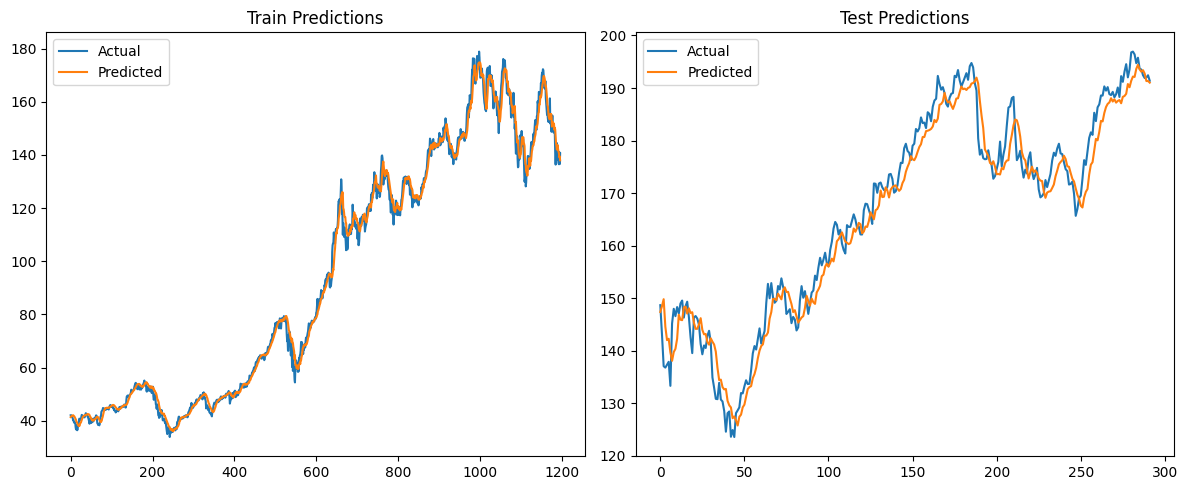

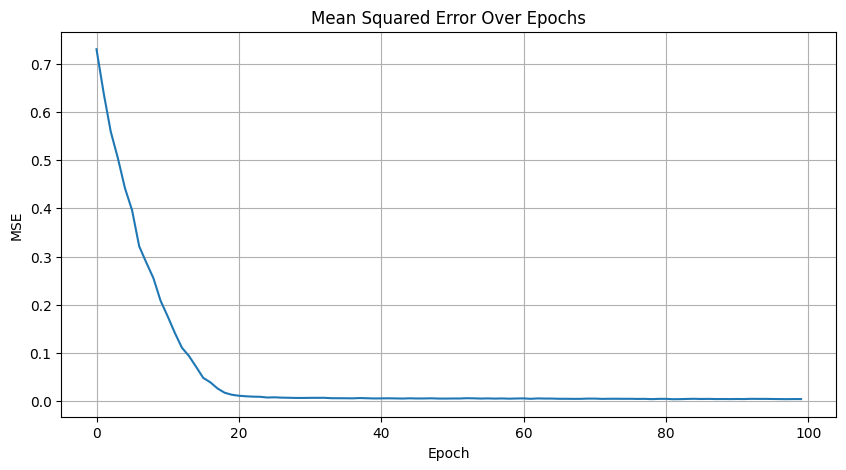

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf

# Set seed
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Load and preprocess data
def download_data():
    df = yf.download("AAPL", start="2018-01-01", end="2023-12-31")
    return df[['Close']]

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

data = download_data()
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
seq_length = 10

train_size = int(0.8 * len(scaled_data))
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train_flat = X_train.reshape(X_train.shape[0], -1).astype(np.float32)
X_test_flat = X_test.reshape(X_test.shape[0], -1).astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

# FF Layer with Top-Down Influence
class FFLayer(tf.keras.layers.Layer):
    def __init__(self, input_dim, units):
        super().__init__()
        self.units = units
        self.w = self.add_weight(shape=(input_dim, units),
                                 initializer='random_normal',
                                 dtype=tf.float32,
                                 trainable=False)
        self.b = self.add_weight(shape=(units,),
                                 initializer='zeros',
                                 dtype=tf.float32,
                                 trainable=False)

    def call(self, inputs):
        return tf.nn.relu(tf.matmul(inputs, self.w) + self.b)

    def local_update(self, pos_input, neg_input, top_down=None, lr=0.01):
        pos_act = tf.nn.relu(tf.matmul(pos_input, self.w) + self.b)
        neg_act = tf.nn.relu(tf.matmul(neg_input, self.w) + self.b)

        if top_down is not None:
            pos_act *= top_down
            neg_act *= top_down

        delta_w = lr * (tf.matmul(tf.transpose(pos_input), pos_act) -
                        tf.matmul(tf.transpose(neg_input), neg_act)) / pos_input.shape[0]
        delta_b = lr * tf.reduce_mean(pos_act - neg_act, axis=0)

        self.w.assign_add(delta_w)
        self.b.assign_add(delta_b)

        return pos_act, tf.reduce_mean(tf.square(pos_act), axis=1), tf.reduce_mean(tf.square(neg_act), axis=1)

# Model with two FFLayers and a readout layer
class FFModel(tf.keras.Model):
    def __init__(self, input_dim):
        super().__init__()
        self.ff1 = FFLayer(input_dim, 128)
        self.ff2 = FFLayer(128, 64)
        self.readout = tf.keras.layers.Dense(1, dtype=tf.float32)

    def call(self, x):
        x1 = self.ff1(x)
        x2 = self.ff2(x1)
        return self.readout(x2)

    def forward(self, x):
        x1 = self.ff1(x)
        x2 = self.ff2(x1)
        return x2  # Output of second FF layer (for top-down)

# Generate positive and negative pairs based on scrambled labels instead of noisy inputs
def generate_pos_neg_pairs(X, y, batch_size):
    # Positive pairs: X with correct labels
    indices = np.random.choice(len(X), batch_size, replace=False)
    X_pos = X[indices]
    y_pos = y[indices]

    # Negative pairs: Same X but with scrambled labels
    # This creates pairs with mismatched input-output relationships
    neg_indices = np.random.permutation(indices)
    X_neg = X[indices]  # Same inputs as positive
    y_neg = y[neg_indices]  # But with shuffled/scrambled labels

    return X_pos, y_pos, X_neg, y_neg

# Training without backpropagation
def train_ff(model, X_train, y_train, epochs=20, batch_size=32):
    history = {'mse': []}

    for epoch in range(epochs):
        epoch_mse = 0
        for i in range(0, len(X_train), batch_size):
            # Get a batch with positive and negative samples
            if i + batch_size > len(X_train):
                # Skip last incomplete batch
                continue

            X_pos, y_pos, X_neg, y_neg = generate_pos_neg_pairs(X_train, y_train, batch_size)
            y_pos = y_pos.reshape(-1, 1)
            y_neg = y_neg.reshape(-1, 1)

            # Forward pass for both positive and negative samples
            h1_pos = model.ff1(X_pos)
            h1_neg = model.ff1(X_neg)

            # Local updates with the Forward-Forward algorithm
            h2_pos, _, _ = model.ff2.local_update(h1_pos, h1_neg)
            _, _, _ = model.ff1.local_update(X_pos, X_neg)

            # Train readout layer on positive samples only
            with tf.GradientTape() as tape:
                y_pred = model.readout(h2_pos)
                mse = tf.reduce_mean(tf.square(y_pos - y_pred))

            gradients = tape.gradient(mse, model.readout.trainable_variables)
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
            optimizer.apply_gradients(zip(gradients, model.readout.trainable_variables))

            epoch_mse += mse.numpy()

        avg_mse = epoch_mse / (len(X_train) // batch_size)
        print(f"Epoch {epoch + 1}: MSE={avg_mse:.4f}")
        history['mse'].append(avg_mse)

    return history

# Evaluation and plot
def evaluate_and_plot(model, X_train, y_train, X_test, y_test, scaler):
    y_train_pred = model(X_train).numpy()
    y_test_pred = model(X_test).numpy()

    y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_train_pred_inv = scaler.inverse_transform(y_train_pred)
    y_test_pred_inv = scaler.inverse_transform(y_test_pred)

    train_rmse = np.sqrt(mean_squared_error(y_train_inv, y_train_pred_inv))
    test_rmse = np.sqrt(mean_squared_error(y_test_inv, y_test_pred_inv))

    print(f"\nTrain RMSE: {train_rmse:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(y_train_inv, label='Actual')
    plt.plot(y_train_pred_inv, label='Predicted')
    plt.title("Train Predictions")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(y_test_inv, label='Actual')
    plt.plot(y_test_pred_inv, label='Predicted')
    plt.title("Test Predictions")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot the learning curve
    plt.figure(figsize=(10, 5))
    plt.plot(history['mse'])
    plt.title('Mean Squared Error Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.grid(True)
    plt.show()

# Run everything
if __name__ == "__main__":
    model = FFModel(input_dim=X_train_flat.shape[1])
    history = train_ff(model, X_train_flat, y_train, epochs=100)
    evaluate_and_plot(model, X_train_flat, y_train, X_test_flat, y_test, scaler)

# LSTM & Transformer


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Layer, Input, LayerNormalization, Add, BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import yfinance as yf
from sklearn.preprocessing import StandardScaler

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Download Yahoo Finance data (Apple stock closing prices)
def download_yahoo_data(ticker="AAPL", start_date="2018-01-01", end_date="2023-12-31"):
    df = yf.download(ticker, start=start_date, end=end_date)
    return df[['Close']]  # Use only closing price for univariate model

# Prepare data
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

df = download_yahoo_data()
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[['Close']])

df = yf.download("AAPL", start="2018-01-01", end="2023-12-31")
df[['Close']].to_csv("aapl_close.csv")

# Parameters
seq_length = 10
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create sequences
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
# Define Transformer Layer
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim)]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training=None, **kwargs):
        attn_output = self.att(inputs, inputs, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [6]:
def create_transformer_model(seq_length):
    inputs = tf.keras.Input(shape=(seq_length, 1))

    # Positional encoding
    pos_encoding = tf.keras.layers.Embedding(seq_length, 64)(tf.range(seq_length))
    x = inputs + pos_encoding

    # Multiple Transformer blocks
    for _ in range(2):  # Two blocks for starters
        x = TransformerBlock(embed_dim=64, num_heads=4, ff_dim=32, rate=0.2)(x)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

In [7]:
# LSTM Model
def create_lstm_model(seq_length):
    model = Sequential([
        Input(shape=(seq_length, 1)),
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

In [8]:
# Train and evaluate models
def train_and_evaluate(model, model_name, X_train, y_train, X_test, y_test):
    # Train model
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

    # Predict
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    # Inverse transform predictions
    train_pred = scaler.inverse_transform(train_pred)
    y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
    test_pred = scaler.inverse_transform(test_pred)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_pred))
    train_mae = mean_absolute_error(y_train_inv, train_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_pred))
    test_mae = mean_absolute_error(y_test_inv, test_pred)

    print(f"\n{model_name} Metrics:")
    print(f"Train RMSE: {train_rmse:.4f}")
    print(f"Train MAE: {train_mae:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Test MAE: {test_mae:.4f}")

    return train_pred, test_pred, y_train_inv, y_test_inv


In [9]:
def plot_results(train_pred, test_pred, y_train_inv, y_test_inv, model_name, data_dates, seq_length):
    plt.figure(figsize=(12, 6))

    # Get full sequence-aligned dates
    full_dates = data_dates[seq_length:]  # offset for sequence length
    train_dates = full_dates[:len(y_train_inv)]
    test_dates = full_dates[len(y_train_inv):len(y_train_inv) + len(y_test_inv)]

    # Plot train data
    plt.subplot(1, 2, 1)
    plt.plot(train_dates, y_train_inv, label='Actual Train')
    plt.plot(train_dates, train_pred, label='Predicted Train')
    plt.title(f'{model_name} - Train Data (AAPL Close Price)')
    plt.xlabel('Date')
    plt.ylabel('Stock Price (USD)')
    plt.xticks(rotation=45)
    plt.legend()

    # Plot test data
    plt.subplot(1, 2, 2)
    plt.plot(test_dates, y_test_inv, label='Actual Test')
    plt.plot(test_dates, test_pred, label='Predicted Test')
    plt.title(f'{model_name} - Test Data (AAPL Close Price)')
    plt.xlabel('Date')
    plt.ylabel('Stock Price (USD)')
    plt.xticks(rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()


Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.4197 - val_loss: 0.0159
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0200 - val_loss: 0.0154
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0144 - val_loss: 0.0207
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0133 - val_loss: 0.0164
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0121 - val_loss: 0.0149
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0132 - val_loss: 0.0155
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0119 - val_loss: 0.0179
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0106 - val_loss: 0.0142
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0097 - val_loss: 0.0143
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0109 - val_loss: 0.0139
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0108 - val_loss: 0.0152
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0

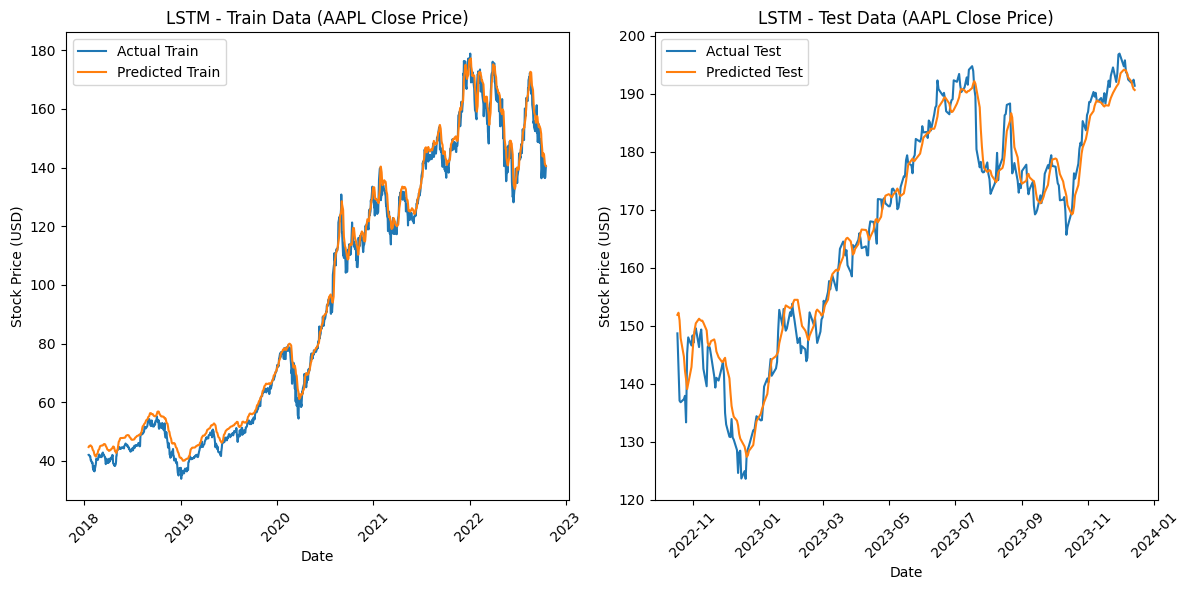

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 0.4590 - val_loss: 0.0614
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.1282 - val_loss: 0.0372
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.1078 - val_loss: 0.0251
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0821 - val_loss: 0.0397
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0673 - val_loss: 0.0227
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0776 - val_loss: 0.0202
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0488 - val_loss: 0.1295
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0612 - val_loss: 0.0553
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0435 - val_loss: 0.1049
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0406 - val_loss: 0.0986
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0465 - val_loss: 0.0184
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.

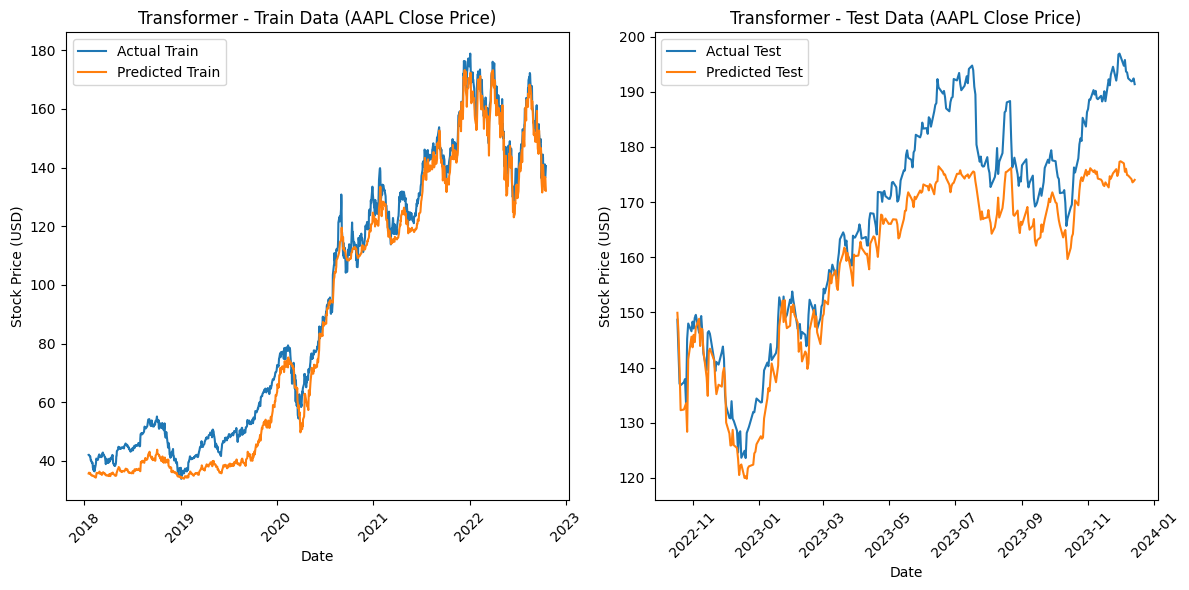

In [10]:
# Main execution
if __name__ == "__main__":
    # LSTM
    lstm_model = create_lstm_model(seq_length)
    lstm_train_pred, lstm_test_pred, y_train_inv, y_test_inv = train_and_evaluate(
        lstm_model, "LSTM", X_train, y_train, X_test, y_test
    )
    plot_results(lstm_train_pred, lstm_test_pred, y_train_inv, y_test_inv, "LSTM", data.index, seq_length)


    # Transformer
    transformer_model = create_transformer_model(seq_length)
    transformer_train_pred, transformer_test_pred, y_train_inv, y_test_inv = train_and_evaluate(
        transformer_model, "Transformer", X_train, y_train, X_test, y_test
    )
    plot_results(transformer_train_pred, transformer_test_pred, y_train_inv, y_test_inv, "Transformer", data.index, seq_length)